[View in Colaboratory](https://colab.research.google.com/github/ntuananh/CS582_MachineLearning/blob/master/MLProject.ipynb)

https://www.youtube.com/watch?v=XOEN9W05_4A - video demo for capturing data

---

In [1]:
#@title Setup Enviroment & Import Data
# Read data from Google Drive
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#List files
#file_list = drive.ListFile({'q': "'11f05x7C5kbWdpTdRJVwbPgV7MOG_D6fv' in parents and trashed=false"}).GetList()
#for file1 in file_list:
#  print('title: %s, id: %s' % (file1['title'], file1['id']))

# create Files and pull content to Colab
train_N = drive.CreateFile({'id': '1qAj6Hqqoss0bAuYuVWGSoOZgmvMkZ6k2'})
train_N.GetContentFile('train_N.csv')
test_N = drive.CreateFile({'id': '1hv9hqdvvTMJGPPqMTsd0YS58_0nio97G'})
test_N.GetContentFile('test_N.csv')

train = drive.CreateFile({'id': '1mXbabpIXPB_57pOvam9bjKOBVnQAoeML'})
train.GetContentFile('train.csv')
test = drive.CreateFile({'id': '1JjEDt8q_VPWfVCN7MOexIwY1I1GtTLfC'})
test.GetContentFile('test.csv')

# read files'content into dataframe
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data_N = pd.read_csv('train_N.csv')
test_data_N = pd.read_csv('test_N.csv')

print('done')

done


In [2]:
#@title Import libraries
#import Libs
import sklearn
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
import seaborn as sns
import matplotlib.pyplot as plt

print('done')

done


In [3]:
import time
import numpy as np
import pandas as pd


class KNearestNeighbour:
    def __init__(self, data: pd.DataFrame, label_column: str, data_dimension=-1):
        self.label_column = label_column
        self.pristine = data.copy()

        # PARSE DATA
        _ = self.pristine.copy()  # copy data before pop
        self.labels = _.pop(label_column)
        self.properties = _.values
        self.size = len(self.labels)

        # REDUCE DIMENSION IF DEFINED
        self.dimension_reduced = False
        if data_dimension > 0:
            self.dimension_reduced = True
            red_dim = self.pca(self.properties, data_dimension)
            self.properties = red_dim[0]
            self.mean = red_dim[1]
            self.ev = red_dim[2]
        self.data_dimension = len(self.properties[0])

        # ORDER AXIS BY MAX VARIANCE
        self.variance_based_axes_index = np.argsort(np.var(self.properties, axis=0))[::-1]

        self.kd_tree_data = self.properties.tolist()
        for d in self.kd_tree_data:
            for f in range(len(d)):
                d[f] = d[f].real
        self.kd_tree_data = [(e, i) for i, e in enumerate(self.kd_tree_data)]

        self.kd_tree = self.build_kd_tree(self.kd_tree_data)

        self.k = None
        self.max_k = int(self.size ** 0.5)

    def optimize_k(self, limit=-1):
        data = self.pristine.copy()

        # BUILD 5-FOLD (train 80%, validation 20%)
        data_splits = [[] for _ in range(5)]
        sid, accuracies = 0, {}
        for d in data.values:
            data_splits[sid].append(d)
            sid = sid + 1 if sid < 4 else 0
        df_splits = [pd.DataFrame(data=data_splits[i], columns=data.columns) for i in range(5)]

        # Brute force to find optimal k
        for i in range(5):
            train = pd.concat([df_splits[j] for j in range(5) if j != i], ignore_index=True)
            test = df_splits[i]
            knn = KNearestNeighbour(train, self.label_column, self.data_dimension)
            max_k = self.max_k if limit < 1 else limit
            for k in range(1, max_k + 1, 2):
                accuracy = KNearestNeighbour.test_model(knn, k, test)[1]
                accuracies[k] = accuracies.get(k, 0) + accuracy
        for k in accuracies:
            accuracies[k] /= 5

        self.k = max(accuracies.keys(), key=(lambda key: accuracies[key]))

    def analyze(self, test_data: list, k: int):
        if self.dimension_reduced:
            test_data = np.transpose(np.dot(np.transpose(self.ev), np.transpose(np.array(test_data) - self.mean)))
        search_result = self.search_kd_tree(self.kd_tree, test_data, k)  # list of e(dist, node)
        ranked_items = []
        rank = 0
        for i in range(len(search_result)):
            label, dist = self.labels[search_result[i][1].original_index], search_result[i][0]
            if i > 0 and dist > search_result[i - 1][0]:
                rank += 1
            ranked_items.append((label, rank))
        label_count_d = {}
        rank_count_d = {}
        for item in ranked_items:
            label_count_d[item[0]] = label_count_d.get(item[0], 0) + 1
            rank_count_d[item[0]] = rank_count_d.get(item[0], 0) + item[1]

        unique_labels = [k for k in label_count_d.keys()]
        label_count = [-label_count_d[k] for k in unique_labels]
        rank_count = [rank_count_d[k] for k in unique_labels]

        sorted_indices = np.lexsort((rank_count, label_count))

        return np.array(unique_labels)[sorted_indices], \
               np.array(label_count)[sorted_indices],   \
               np.array(rank_count)[sorted_indices],    \
               len(ranked_items)

    def build_kd_tree(self, points, depth=0):
        data_size = len(points)
        if data_size < 1:
            return None
        axis = self.variance_based_axes_index[depth % self.data_dimension]
        points.sort(key=lambda e: e[0][axis])
        median = data_size // 2
        while median + 1 < data_size and points[median][0][axis] == points[median + 1][0][axis]:
            median += 1
        return KNearestNeighbour.KDTreeNode(
            points[median][1],
            points[median][0],
            self.build_kd_tree(points[:median], depth + 1),
            self.build_kd_tree(points[median + 1:], depth + 1)
        )

    def search_kd_tree(self, kd_tree, test_data, k: int):
        kml = KNearestNeighbour.KMinList(k)

        def _kd_search(kd_tree, test_data, depth=0):
            if kd_tree is None:
                return
            nonlocal kml

            axis = self.variance_based_axes_index[depth % self.data_dimension]
            goes_left = True
            if test_data[axis] <= kd_tree.location[axis]:
                _kd_search(kd_tree.left, test_data, depth + 1)
            else:
                goes_left = False
                _kd_search(kd_tree.right, test_data, depth + 1)

            dist = KNearestNeighbour.manhattan_distance(test_data, kd_tree.location)
            kml.insert((dist, kd_tree))

            splitting_coor_diff = abs(test_data[axis] - kd_tree.location[axis])
            max_nearest_dist = kml.max()[0]

            if not kml.is_full() or splitting_coor_diff < max_nearest_dist:
                if goes_left:
                    _kd_search(kd_tree.right, test_data, depth + 1)
                else:
                    _kd_search(kd_tree.left, test_data, depth + 1)

        _kd_search(kd_tree, test_data)
        return [e for e in kml.elements()]

    @classmethod
    def manhattan_distance(cls, p1: list, p2: list) -> float:
        return sum([abs(e[0] - e[1]) for e in zip(p1, p2)])

    @classmethod
    def euclidean_distance(cls, p1: list, p2: list) -> float:
        return sum(np.square(np.array(p1) - np.array(p2))) ** 0.5

    @classmethod
    def verdict(cls, analyze_result):
        return analyze_result[0][0]

    @classmethod
    def explain(cls, analyze_result):
        return list(zip(
            analyze_result[0],
            [round(-e/analyze_result[3], 2) for e in analyze_result[1]],
            analyze_result[2]
        ))

    @classmethod
    def pca(cls, data, n_components):
        mean = np.mean(data, axis=0)
        data -= mean
        cov_matrix = np.cov(np.transpose(data))

        eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)
        indices = np.argsort(eigen_values)[::-1]
        eigen_vectors = eigen_vectors[:, indices]
        eigen_vectors = eigen_vectors[:, :n_components]
        for i in range(np.shape(eigen_vectors)[1]):
            eigen_vectors[:, i] /= np.linalg.norm(eigen_vectors[:, i])

        transformed_data = np.transpose(np.dot(np.transpose(eigen_vectors), np.transpose(data)))
        # original_data = np.transpose(np.dot(evecs, x)) + m
        return transformed_data, mean, eigen_vectors

    @classmethod
    def test_model(cls, model, k: int, tests: pd.DataFrame, build_confusion_matrix: bool=False):
        _ = tests.copy()
        expected_labels = _.pop(model.label_column)
        tests = _.values

        success_count = 0
        failed_tests = []
        total_time = 0

        confusion_matrix = None
        labels_mapping = None
        if build_confusion_matrix:
            labels = np.unique(np.array(model.labels))
            confusion_matrix = np.zeros((len(labels), len(labels)))
            labels_mapping = {l: i for i, l in enumerate(labels)}

        for i, test in enumerate(tests):
            start = time.clock()

            analyze_result = model.analyze(test, k)
            result = KNearestNeighbour.verdict(analyze_result)

            end = time.clock()
            total_time += end - start
            if expected_labels[i] == result:
                success_count += 1
            else:
                failed_tests.append((i, expected_labels[i], KNearestNeighbour.explain(analyze_result)))
            if build_confusion_matrix:
                confusion_matrix[labels_mapping[expected_labels[i]], labels_mapping[result]] += 1

        success_rate = success_count / len(tests)

        return total_time, success_rate, failed_tests, confusion_matrix, labels_mapping

    class KDTreeNode:
        def __init__(self, original_index, location, left, right):
            self.original_index = original_index
            self.location = location
            self.left = left
            self.right = right

    class KMinList:
        class Node:
            def __init__(self, element):
                self.element = element
                self.next, self.prev = None, None

        def __init__(self, k: int):
            self.k = k
            self.len = 0
            self.head, self.tail = None, None

        def insert_before(self, node, new_node):
            if self.head is None:
                self.head = new_node
                self.tail = self.head
            elif self.head == node:
                self.head.prev = new_node
                new_node.next = self.head
                self.head = new_node
            else:
                prev_node = node.prev
                prev_node.next = new_node
                new_node.prev = prev_node
                node.prev = new_node
                new_node.next = node

        def insert(self, element):
            new_node = KNearestNeighbour.KMinList.Node(element)
            key = element[0]
            if self.tail is not None and self.tail.element[0] < key:
                self.tail.next = new_node
                new_node.prev = self.tail
                self.tail = new_node
            else:
                p = self.head
                while p is not None and p.element[0] < key:
                    p = p.next
                self.insert_before(p, new_node)
            self.len += 1
            if self.len > self.k:
                self.len = self.k
                self.tail = self.tail.prev
                self.tail.next = None

        def is_full(self):
            return self.len == self.k

        def elements(self):
            result = []
            p = self.head
            while p is not None:
                result.append(p.element)
                p = p.next
            return result

        def max(self):
            return self.tail.element

print('done')
if __name__ == '__main__':
    data = pd.read_csv(r'..\data\human_act_recognition\train.csv')
    tests = pd.read_csv(r'..\data\human_act_recognition\test.csv')

    knn = KNearestNeighbour(data, 'activity', 10)
    # knn.optimize_k()

    t = KNearestNeighbour.test_model(knn, 3, tests)

    for ft in t[2]:
        print('Failed Test Index: ' + str(ft[0]))
        print('Expected: ' + str(ft[1]))
        print('Actual Result: ' + str(ft[2]))  # (label, vote freq, total rank - the smaller the better)
        print()

done


Time
31.215972000000036
Acuracy
0.969521044992743
Fail tests
Failed Test Index: 9
Expected: LAYING
Actual Result: [('SITTING', 0.67, 3), ('LAYING', 0.33, 0)]

Failed Test Index: 10
Expected: LAYING
Actual Result: [('WALKING', 0.67, 3), ('LAYING', 0.33, 0)]

Failed Test Index: 14
Expected: WALKING_DOWNSTAIRS
Actual Result: [('WALKING_UPSTAIRS', 0.67, 1), ('WALKING', 0.33, 2)]

Failed Test Index: 24
Expected: WALKING_DOWNSTAIRS
Actual Result: [('WALKING', 0.67, 3), ('WALKING_DOWNSTAIRS', 0.33, 0)]

Failed Test Index: 81
Expected: SITTING
Actual Result: [('STANDING', 0.67, 2), ('SITTING', 0.33, 1)]

Failed Test Index: 161
Expected: LAYING
Actual Result: [('SITTING', 0.67, 3), ('LAYING', 0.33, 0)]

Failed Test Index: 177
Expected: LAYING
Actual Result: [('SITTING', 0.67, 3), ('LAYING', 0.33, 0)]

Failed Test Index: 203
Expected: WALKING_DOWNSTAIRS
Actual Result: [('WALKING_UPSTAIRS', 0.67, 3), ('WALKING_DOWNSTAIRS', 0.33, 0)]

Failed Test Index: 205
Expected: SITTING
Actual Result: [('STAN

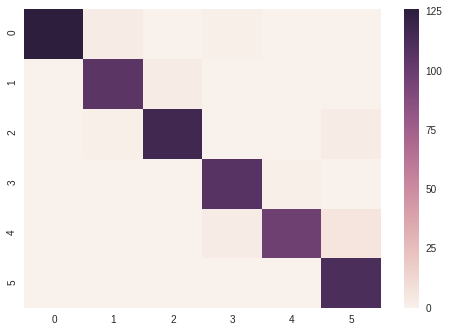

In [4]:
#@title KNearestNeighbour with PCA=10, KNN=3, Accu=0.969
# Run custom KNN

train = train_data_N.copy()
test  = test_data_N.copy()

knn = KNearestNeighbour(train, 'activity', 10)
t   = KNearestNeighbour.test_model(knn, 3, test, build_confusion_matrix=True)

print('Time')
print(t[0])

print('Acuracy')
print(t[1])

print('Fail tests')
for ft in t[2]:
  print('Failed Test Index: ' + str(ft[0]))
  print('Expected: ' + str(ft[1]))
  print('Actual Result: ' + str(ft[2]))  # (label, vote freq, total rank - the smaller the better)
  print()

print('Confusion Maxtrix')
print(t[3])
sns.heatmap(t[3])

Time
0.18615299999997603
Acuracy
0.9274310595065312
Confusion Maxtrix
[[119.   3.   0.   8.   0.   0.]
 [  1. 107.   1.   0.   0.   0.]
 [  0.   4. 114.   0.   0.   3.]
 [  7.   0.   0.  97.   5.   0.]
 [  0.   0.   0.   5.  96.   6.]
 [  0.   0.   2.   0.   5. 106.]]


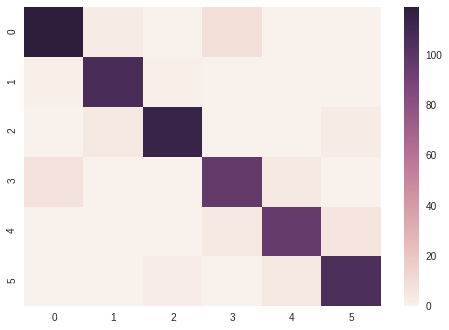

In [5]:
#@title KNearestNeighbour with PCA=1, KNN=1, Accuracy= 0.927

train = train_data_N.copy()
test  = test_data_N.copy()

knn = KNearestNeighbour(train, 'activity', 1)
t = KNearestNeighbour.test_model(knn, 1, test, build_confusion_matrix=True)

print('Time')
print(t[0])

print('Acuracy')
print(t[1])

print('Confusion Maxtrix')
print(t[3])
sns.heatmap(t[3])

In [13]:
#@title KNearestNeighbour table { display-mode: "code" }
# Run custom KNN

train = train_data_N.copy()
test  = test_data_N.copy()

# pca=500,knn=3
knn = KNearestNeighbour(train, 'activity', 500)
t = KNearestNeighbour.test_model(knn, 3, test, build_confusion_matrix=True)

print('pca=500,knn=3, Acuracy:')
print(t[1])
print('Confusion Maxtrix')
print(t[3])

train = train_data_N.copy()
test  = test_data_N.copy()

# pca=250,knn=3
knn = KNearestNeighbour(train, 'activity', 250)
t = KNearestNeighbour.test_model(knn, 3, test, build_confusion_matrix=True)

print('pca=250,knn=3, Acuracy:')
print(t[1])
print('Confusion Maxtrix')
print(t[3])


train = train_data_N.copy()
test  = test_data_N.copy()

# pca=100,knn=3
knn = KNearestNeighbour(train, 'activity', 100)
t = KNearestNeighbour.test_model(knn, 3, test, build_confusion_matrix=True)

print('pca=100,knn=3, Acuracy:')
print(t[1])
print('Confusion Maxtrix')
print(t[3])


train = train_data_N.copy()
test  = test_data_N.copy()

# pca=50,knn=3
knn = KNearestNeighbour(train, 'activity', 50)
t = KNearestNeighbour.test_model(knn, 3, test, build_confusion_matrix=True)

print('pca=50,knn=3, Acuracy:')
print(t[1])
print('Confusion Maxtrix')
print(t[3])


train = train_data_N.copy()
test  = test_data_N.copy()

# pca=10,knn=3
knn = KNearestNeighbour(train, 'activity', 10)
t = KNearestNeighbour.test_model(knn, 3, test, build_confusion_matrix=True)

print('pca=10,knn=3, Acuracy:')
print(t[1])
print('Confusion Maxtrix')
print(t[3])


pca=500,knn=3, Acuracy:
0.969521044992743
Confusion Maxtrix
[[123.   7.   0.   0.   0.   0.]
 [  0. 105.   4.   0.   0.   0.]
 [  0.   2. 117.   0.   0.   2.]
 [  0.   0.   0. 109.   0.   0.]
 [  0.   0.   0.   4. 101.   2.]
 [  0.   0.   0.   0.   0. 113.]]
pca=250,knn=3, Acuracy:
0.9709724238026125
Confusion Maxtrix
[[124.   6.   0.   0.   0.   0.]
 [  0. 105.   4.   0.   0.   0.]
 [  0.   2. 117.   0.   0.   2.]
 [  0.   0.   0. 109.   0.   0.]
 [  0.   0.   0.   4. 101.   2.]
 [  0.   0.   0.   0.   0. 113.]]
pca=100,knn=3, Acuracy:
0.9724238026124818
Confusion Maxtrix
[[125.   5.   0.   0.   0.   0.]
 [  0. 106.   3.   0.   0.   0.]
 [  0.   2. 117.   0.   0.   2.]
 [  0.   0.   0. 108.   1.   0.]
 [  0.   0.   0.   4. 101.   2.]
 [  0.   0.   0.   0.   0. 113.]]
pca=50,knn=3, Acuracy:
0.9709724238026125
Confusion Maxtrix
[[125.   4.   0.   1.   0.   0.]
 [  0. 106.   3.   0.   0.   0.]
 [  0.   1. 118.   0.   0.   2.]
 [  0.   0.   0. 108.   1.   0.]
 [  0.   0.   0.   4.  99.   

In [22]:
#@title KNearestNeighbour table { display-mode: "code" }
# Run custom KNN

train = train_data_N.copy()
test  = test_data_N.copy()

# pca=500,knn=1
knn = KNearestNeighbour(train, 'activity', 500)
t = KNearestNeighbour.test_model(knn, 1, test, build_confusion_matrix=True)

print('pca=500,knn=1, Acuracy:')
print(t[1])
print('Confusion Maxtrix')
print(t[3])

train = train_data_N.copy()
test  = test_data_N.copy()

# pca=250,knn=1
knn = KNearestNeighbour(train, 'activity', 250)
t = KNearestNeighbour.test_model(knn, 1, test, build_confusion_matrix=True)

print('pca=250,knn=1, Acuracy:')
print(t[1])
print('Confusion Maxtrix')
print(t[3])


train = train_data_N.copy()
test  = test_data_N.copy()

# pca=100,knn=1
knn = KNearestNeighbour(train, 'activity', 100)
t = KNearestNeighbour.test_model(knn, 1, test, build_confusion_matrix=True)

print('pca=100,knn=1, Acuracy:')
print(t[1])
print('Confusion Maxtrix')
print(t[3])


train = train_data_N.copy()
test  = test_data_N.copy()

# pca=50,knn=1
knn = KNearestNeighbour(train, 'activity', 50)
t = KNearestNeighbour.test_model(knn, 1, test, build_confusion_matrix=True)

print('pca=50,knn=1, Acuracy:')
print(t[1])
print('Confusion Maxtrix')
print(t[3])


train = train_data_N.copy()
test  = test_data_N.copy()

# pca=10,knn=1
knn = KNearestNeighbour(train, 'activity', 10)
t = KNearestNeighbour.test_model(knn, 1, test, build_confusion_matrix=True)

print('pca=10,knn=1, Acuracy:')
print(t[1])
print('Confusion Maxtrix')
print(t[3])


pca=500,knn=1, Acuracy:
0.9854862119013063
Confusion Maxtrix
[[129.   1.   0.   0.   0.   0.]
 [  0. 105.   4.   0.   0.   0.]
 [  0.   1. 119.   0.   0.   1.]
 [  0.   0.   0. 109.   0.   0.]
 [  0.   0.   0.   1. 104.   2.]
 [  0.   0.   0.   0.   0. 113.]]
pca=250,knn=1, Acuracy:
0.9869375907111756
Confusion Maxtrix
[[130.   0.   0.   0.   0.   0.]
 [  0. 105.   4.   0.   0.   0.]
 [  0.   1. 119.   0.   0.   1.]
 [  0.   0.   0. 109.   0.   0.]
 [  0.   0.   0.   1. 104.   2.]
 [  0.   0.   0.   0.   0. 113.]]
pca=100,knn=1, Acuracy:
0.988388969521045
Confusion Maxtrix
[[130.   0.   0.   0.   0.   0.]
 [  0. 106.   3.   0.   0.   0.]
 [  0.   1. 119.   0.   0.   1.]
 [  0.   0.   0. 109.   0.   0.]
 [  0.   0.   0.   1. 104.   2.]
 [  0.   0.   0.   0.   0. 113.]]
pca=50,knn=1, Acuracy:
0.9912917271407837
Confusion Maxtrix
[[130.   0.   0.   0.   0.   0.]
 [  0. 108.   1.   0.   0.   0.]
 [  0.   1. 119.   0.   0.   1.]
 [  0.   0.   0. 109.   0.   0.]
 [  0.   0.   0.   2. 104.   

In [32]:
train = train_data_N.copy()
test  = test_data_N.copy()

# pca=1,knn=1
knn = KNearestNeighbour(train, 'activity',10)
t = KNearestNeighbour.test_model(knn, 1, test, build_confusion_matrix=True)

print('pca=1,knn=1, Acuracy:')
print(t[1])
print('time:')
print(t[0])
print('Confusion Maxtrix')
print(t[3])

pca=1,knn=1, Acuracy:
0.9927431059506531
time:
46.090129000004254
Confusion Maxtrix
[[130.   0.   0.   0.   0.   0.]
 [  0. 107.   2.   0.   0.   0.]
 [  0.   0. 120.   0.   0.   1.]
 [  0.   0.   0. 109.   0.   0.]
 [  0.   0.   0.   0. 106.   1.]
 [  0.   0.   0.   0.   1. 112.]]


# Backup

##Upload files to Colab
```
from google.colab import files
files.upload()
files.os.listdir()
```

##Download dataset from Kaggle
```
!pip install kaggle
!mkdir .kaggle

import json
token = {"username":"nguyentuananh","key":"44e2c22b301712101fdafe3d03ff7898"}
with open('.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!chmod 600 .kaggle/kaggle.json

!kaggle datasets download -d mboaglio/simplifiedhuarus
```

In [0]:
#@title UMAP
!pip install umap-learn
#First we reduce original train_data with UMAP
#Then run the fit with KNN model

train_data = pd.read_csv('train.csv')
y = train_data.pop('activity')
x = train_data

# initialize UMAP
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(x)

# fit model based on the embedding
knn_model = KNeighborsClassifier(algorithm='brute',n_neighbors=3)
knn_model.fit(embedding,y)

test_data = pd.read_csv('test.csv')
#????not sure trying to transform the test data before testing is correct, but just give it a try
embedding_test = reducer.fit_transform(test_data)

predictions = knn_model.predict(embedding_test)
print(predictions)
#not as expected - FAILED
#how to use the test data, if the original train data already reduced?
knn_model.score(embedding,y)
#0.9542809642560266 - not as expected - FAILED

In [5]:
#@title KDTree
#https://en.wikipedia.org/wiki/K-d_tree
  
from collections import namedtuple
from operator import itemgetter
from pprint import pformat

class Node(namedtuple('Node', 'location left_child right_child')):
    def __repr__(self):
        return pformat(tuple(self))

def kdtree(point_list, depth=0):
    try:
        k = len(point_list[0]) # assumes all points have the same dimension
    except IndexError as e: # if not point_list:
        return None
    # Select axis based on depth so that axis cycles through all valid values
    axis = depth % k
 
    # Sort point list and choose median as pivot element
    point_list.sort(key=itemgetter(axis))
    median = len(point_list) // 2 # choose median
 
    # Create node and construct subtrees
    return Node(
        location=point_list[median],
        left_child=kdtree(point_list[:median], depth + 1),
        right_child=kdtree(point_list[median + 1:], depth + 1)
    )

def main():
    """Example usage"""
    point_list = [(2,3), (5,4), (9,6), (4,7), (8,1), (7,2)]
    tree = kdtree(point_list)
    print(tree)

if __name__ == '__main__':
    main()

((7, 2),
 ((5, 4), ((2, 3), None, None), ((4, 7), None, None)),
 ((9, 6), ((8, 1), None, None), None))


In [24]:
#@title KNeighborsClassifier PCA=10, KNN=3, Accu=0.971
#Run scikitlearn with pca, KNN

# split out activity (target column) to Y
train = train_data_N.copy()
test  = test_data_N.copy()
Y = train.pop('activity')
X = train

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

#Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X1 = pca.fit_transform(X_train)


#-------------
#default training method
knn_model = KNeighborsClassifier(algorithm='brute',n_neighbors=3)
knn_model.fit(X1, Y_train)

#test predict
pca = PCA(n_components=10)
actualResult = test.pop('activity')

Xtest = pca.fit_transform(test)

predictions = knn_model.predict(Xtest)
#print(predictions)
score = knn_model.score(X1,Y_train)
print(score)
# 0.9866999168744804


0.9678938356164384
